In [1]:
#https://pubs.acs.org/doi/10.1021/acs.jctc.2c01057
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy import linalg as LA
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
# from qiskit.tools.visualization import plot_histogram
from IPython.display import clear_output
import math


# 这个HEA的模型，有很大问题！

TFIM setting is the same as TFIM_GD_HEA2.ipynb

As a brief illustration of the performance of noisy GD versus RCD methods, we consider the transverse-field Ising model,

$$
H=J \sum_{j=1}^{N-1} Z_j Z_{j+1}+\Delta \sum_{j=1}^N X_j
$$

with the coefficient $J=1$ and $\Delta=1.5$. Here $N$ denotes the number of qubits, and $X_j, Z_j$ are Pauli operators acting on the $j$-th qubit. In Fig. 1, we set $N=10$. To implement the

In [2]:

num_q = 4
J = 1
Delta = 1.5
List_1 = []
op = ""
for i in range(num_q-1):
    op = ""

    # I's before ZZ
    for k in range(i):
        op += "I"

    op += "ZZ"

    # I's after ZZ
    for k in range(i+1,num_q-1):
        op += "I"

    List_1.append(op) # ['ZZII', 'IZZI', 'IIZZ']

List_1.reverse() # ['IIZZ', 'IZZI', 'ZZII']

# example:
# for num_q = 5, List_1 = ['IIIZZ', 'IIZZI', 'IZZII', 'ZZIII']
# for num_q = 6, List_1 = ['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII']

H1 = SparsePauliOp(List_1, J*np.ones(num_q-1))  

print(List_1)
print(H1)

['IIZZ', 'IZZI', 'ZZII']
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])


In [3]:
List_2 = []
op = ""
for i in range(num_q):
    op = ""
    # I's before X
    for k in range(i):
        op += "I"

    op += "X"
    # I's after X
    for k in range(i+1,num_q):
        op += "I"

    List_2.append(op) # ['XIII', 'IXII', 'IIXI', 'IIIX']

H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

print(List_2)
print(H2)

['XIII', 'IXII', 'IIXI', 'IIIX']
SparsePauliOp(['XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j])


In [4]:
H = SparsePauliOp.sum([H1,H2])

# Ordering e.g. IIIIIIZZ is the measurement of Z gates on the first two qubits and so forth.

Hmat = Operator(H)
Hmat = Hmat.data # This is the matrix representation of the Hamiltonian

e, v = LA.eig(Hmat) # Compute the eigenvalues and right eigenvectors of a square array.
min_index = np.argmin(e)
v_min = v[:,min_index] # ground state eigenvector
ground_e = np.min(e) # ground state energy

print(H[0])
print(np.min(e))

print(H.size) # 7
print(H.paulis[0])
print(H.paulis) # ['IIZZ', 'IZZI', 'ZZII', 'XIII', 'IXII', 'IIXI', 'IIIX']

scipy.io.savemat('Hmat.mat',{'Hmat':Hmat})


SparsePauliOp(['IIZZ'],
              coeffs=[1.+0.j])
(-6.5038915571264155+0j)
7
IIZZ
['IIZZ', 'IZZI', 'ZZII', 'XIII', 'IXII', 'IIXI', 'IIIX']


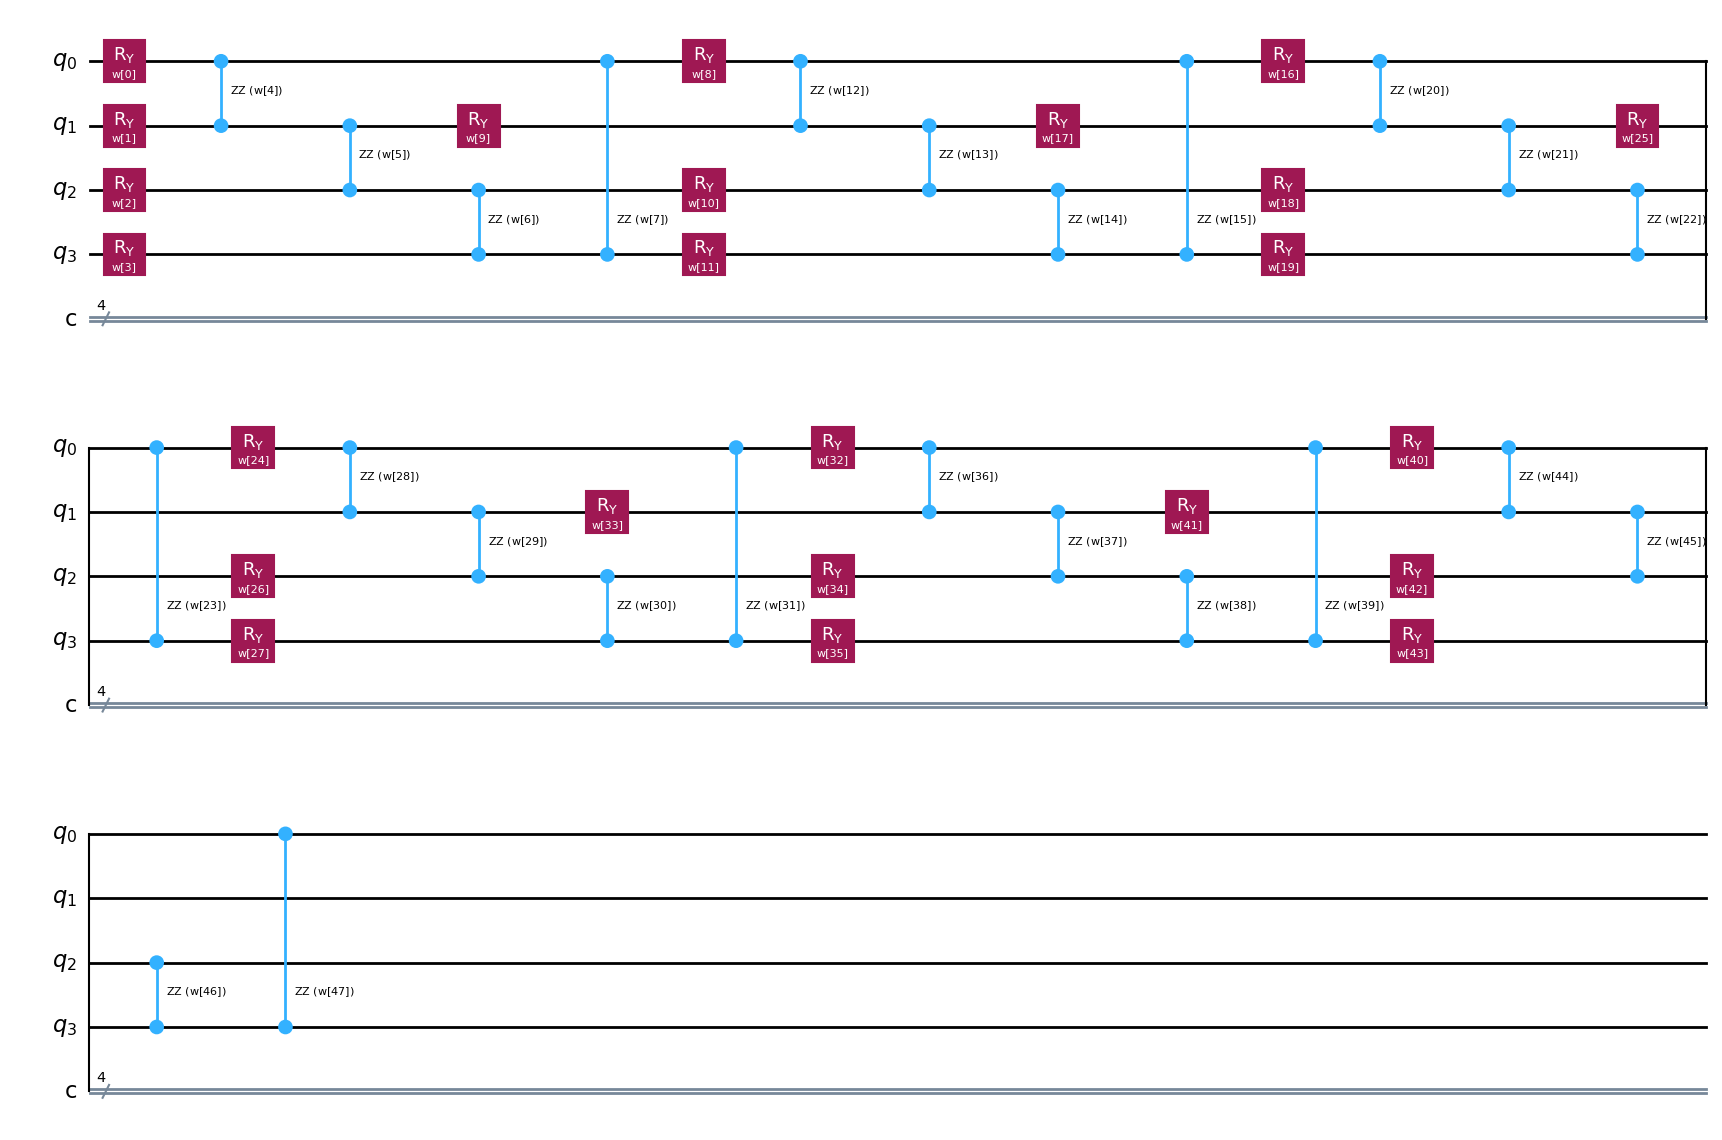

In [5]:
"""circuit construction"""
# num_q = 5

# default layer = 6
layer = 6 # qc.draw('mpl')时，注意第二层之后的 RY 会被推到前面去
num_p = 2*num_q*layer 
weights = ParameterVector("w",num_p)

def circuit_ex(weights):
    circ = QuantumCircuit(num_q, num_q)
    for i in range(layer):
        # RY
        for j in range(num_q):
            circ.ry(weights[2*num_q*i+j], j)
        # RZZ
        for j in range(num_q-1):
            circ.rzz(weights[2*num_q*i+num_q+j], j, j+1)
        # RZZ 末尾和第一个连接起来
        circ.rzz(weights[2*num_q*i+2*num_q-1], num_q-1, 0) 
    return circ 

qc=circuit_ex(weights)
qc.draw('mpl')

In [6]:
simulator = AerSimulator()

def weight_converter(WEIGHTS):
    weight_long = []  # Initialize an empty list to store the result
    
    # Outer loop runs 2 * layer times
    for j in range(2 * layer):
        # 这里不需要区分奇偶，应该
        # 默认 num_q = 4
        if j % 2 == 0:  # If 'j' is even
            for i in range(num_q):  # Inner loop runs 'num_q' times
                weight_long.append(WEIGHTS[j])  # Append WEIGHTS[j] to weight_long
        else:  # If 'j' is odd
            for i in range(num_q):  # Inner loop runs 'num_q' times
                weight_long.append(WEIGHTS[j])  # Append WEIGHTS[j] to weight_long
    
    return weight_long  # Return the modified list 'weight_long'




In [ ]:

def estimate_loss(WEIGHT_long, SHOTS):
    # for WEIGHT_long !!


    estimate = 0
    qc = circuit_ex(WEIGHT_long)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1
    for i in range(SHOTS):
        for j in range(num_q-1):
            if c[i][num_q-1-j] == c[i][num_q-1-(j+1)]:
                estimate += 1
            else:
                estimate += -1
    estimate = J*estimate/SHOTS
    
    estimate_1 = 0
    qc = circuit_ex(WEIGHT_long)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        for j in range(num_q):
            if c[i][num_q-1-j] == '0':
                estimate_1 += 1
            else:
                estimate_1 += -1
    estimate_1 = Delta*estimate_1/SHOTS
    
    return estimate+estimate_1

def parameter_shift(WEIGHTS, INDEX, SHOTS):
    # for INDEX in range(num_p_real)
    WEIGHT_long = weight_converter(WEIGHTS)##

    identity = np.identity(num_p) # 很长的num_p
    g = 0
    if INDEX % 2 == 0: #Y layer
        INDEX_new = int(INDEX/2)*(2*num_q)

        for i in range(num_q):
            # 累加g
            direction_index = np.pi/2 *identity[:,INDEX_new+i]
            g_p = estimate_loss((WEIGHT_long+direction_index.flatten()), SHOTS)
            g_m = estimate_loss((WEIGHT_long-direction_index.flatten()), SHOTS)
            # tsts = 0.5*(g_p-g_m)
            # print(tsts)
            g += tsts
    else: ## ZZ layer
        INDEX_new = int(np.floor(INDEX/2))*(2*num_q)+num_q

        for i in range(num_q):
            direction_index = np.pi/2 *identity[:,INDEX+i]
            g_p = estimate_loss((WEIGHT_long+direction_index.flatten()), SHOTS)
            g_m = estimate_loss((WEIGHT_long-direction_index.flatten()), SHOTS)
            g += 0.5*(g_p-g_m) ## parameter shift rule with eigenvalues +-0.5

    return g

def expectation_loss(WEIGHTS):
    WEIGHT_long = weight_converter(WEIGHTS) ##

    qc = circuit_ex(WEIGHT_long)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)

def fidelity(WEIGHTS):
    WEIGHT_long = weight_converter(WEIGHTS) ##

    qc = circuit_ex(WEIGHT_long)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    return np.absolute(np.vdot(psi,v_min))**2

In [8]:
"""optimization phase"""



"""initialization of weights"""
mat = scipy.io.loadmat('w0')
w0 = mat['w0']


# num_p = 2*num_q*layer 
# num_p_real ???
num_p_real = 2*layer

initial_weights = np.zeros(num_p_real) #np.ones(num_p)
initial_weights[:10] = w0.flatten()


# initial_weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]  # Example weights
wlong=weight_converter(initial_weights)

print(wlong)
print(initial_weights)

# wulong is four times longer than initial_weights
# just copy every entry four times.
# ex.
# [0.7811799999999997, 0.7811799999999997, 0.7811799999999997, 0.7811799999999997, 0.9019199999999999, 0.9019199999999999, 0.9019199999999999, 0.9019199999999999, 1.2370900000000002, 1.2370900000000002, 1.2370900000000002, 1.2370900000000002, 0.92616, 0.92616, 0.92616, 0.92616, 1.03451, 1.03451, 1.03451, 1.03451, 1.14008, 1.14008, 1.14008, 1.14008, 1.0368899999999999, 1.0368899999999999, 1.0368899999999999, 1.0368899999999999, 0.8531199999999999, 0.8531199999999999, 0.8531199999999999, 0.8531199999999999, 0.8350099999999999, 0.8350099999999999, 0.8350099999999999, 0.8350099999999999, 1.0098399999999998, 1.0098399999999998, 1.0098399999999998, 1.0098399999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# [0.78118 0.90192 1.23709 0.92616 1.03451 1.14008 1.03689 0.85312 0.83501
#  1.00984 0.      0.     ]


[0.7811799999999997, 0.7811799999999997, 0.7811799999999997, 0.7811799999999997, 0.9019199999999999, 0.9019199999999999, 0.9019199999999999, 0.9019199999999999, 1.2370900000000002, 1.2370900000000002, 1.2370900000000002, 1.2370900000000002, 0.92616, 0.92616, 0.92616, 0.92616, 1.03451, 1.03451, 1.03451, 1.03451, 1.14008, 1.14008, 1.14008, 1.14008, 1.0368899999999999, 1.0368899999999999, 1.0368899999999999, 1.0368899999999999, 0.8531199999999999, 0.8531199999999999, 0.8531199999999999, 0.8531199999999999, 0.8350099999999999, 0.8350099999999999, 0.8350099999999999, 0.8350099999999999, 1.0098399999999998, 1.0098399999999998, 1.0098399999999998, 1.0098399999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.78118 0.90192 1.23709 0.92616 1.03451 1.14008 1.03689 0.85312 0.83501
 1.00984 0.      0.     ]


In [9]:



T = 20
n_shot = 1000


identity = np.identity(num_p_real)
num_results = 1
cost_mat = np.empty((0,T), int)
weight_mat = np.empty((0,T), int)
fidelity_mat = np.empty((0,T), int)
F = 0
iteration = 0
loss = 0 

for l in range(num_results):
    cost = []
    cost_f = []
    Weights = []
    weights = initial_weights
    iteration = 0
    while iteration < T:
        a = 0.006

        iteration = iteration + 1

        gradient = []
        for j in range(num_p_real):
            index = j
            partial_gradient = parameter_shift(weights, index, n_shot)
            gradient.append(partial_gradient)
        gradient = np.array(gradient)

        weights = weights - a*gradient
        Weights.append(weights)

        F = fidelity(weights)
        loss = expectation_loss(weights)

        # clear_output(wait=True)
        # print('Loss and Fidelity:',loss, fidelity(weights))
        
        # plt.plot(cost)
        # plt.xlabel('iteration')
        # plt.title('GD')
        # plt.show()
        cost.append(loss.flatten())
        cost_f.append(F.flatten()) 
           
    Cost = np.asarray(cost)
    WEIGHTS = np.asarray(Weights)
    FIDELITY = np.asarray(cost_f)
    cost_mat = np.append(cost_mat, np.transpose(Cost), axis = 0)
    weight_mat = np.append(weight_mat, np.transpose(WEIGHTS), axis = 0)
    fidelity_mat = np.append(fidelity_mat, np.transpose(FIDELITY), axis = 0)
    
scipy.io.savemat('gd_loss.mat', {'gd_loss': cost_mat})
scipy.io.savemat('gd_weight.mat', {'gd_weight': weight_mat})
scipy.io.savemat('gd_fidelity.mat', {'gd_fidelity': fidelity_mat})

plt.plot(cost)
plt.xlabel('iteration')
plt.title('GD')
plt.show()

0.7859999999999998
0.8519999999999999
0.766
0.861
0.22000000000000008
0.376
0.2935
0.3275
0.36649999999999994
0.22899999999999998
0.16899999999999993
0.3320000000000001
1.3760000000000001
1.4805
1.452
1.278
-0.22599999999999998
-0.11299999999999988
-0.15850000000000003
-0.21249999999999997
1.2395
1.3319999999999999
1.2485
1.213
0.9995000000000002
0.9159999999999999
0.9655
1.015
0.278
0.3545
0.28600000000000003
0.21599999999999997
0.35849999999999993
0.23650000000000004
0.381
0.4685
1.4915
1.335
1.411
1.3809999999999998
-0.13549999999999995
-0.31050000000000005
-0.08800000000000002
-0.119
1.1755
1.4304999999999999
1.4905
1.217
1.0485
1.034
1.171
1.224
0.27
0.43799999999999994
0.333
0.25749999999999995
0.4455
0.3799999999999999
0.504
0.504
1.4305
1.4485000000000001
1.345
1.441
-0.3365
-0.15849999999999992
-0.17699999999999988
-0.26949999999999985
1.294
1.6784999999999999
1.5625
1.2389999999999999
1.0270000000000001
1.2055
1.2269999999999999
1.2039999999999997
0.1975
0.40249999999999997
0

KeyboardInterrupt: 